In [3]:
!uv pip install langgraph

Using Python 3.11.10 environment at: /home/ubu/Documents/work/l4t/ai-python-series/langchain-langgraph-python/.venv
Audited 1 package in 2ms


In [4]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from dotenv import load_dotenv
from IPython.display import Image, display
import os

In [5]:
@tool
def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"


model = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY")).bind_tools([weather_search])

class State(MessagesState):
    """Simple state."""


def agent_node(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["agent_node", "tool_node"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="tool_node")

    # update the AI message AND call tools
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }
        return Command(goto="tool_node", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="agent_node", update={"messages": [tool_message]})


def tool_node(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}


def route_after_agent_node(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(State)
builder.add_node(agent_node)
builder.add_node(tool_node)
builder.add_node(human_review_node)
builder.add_edge(START, "agent_node")
builder.add_conditional_edges("agent_node", route_after_agent_node)
builder.add_edge("tool_node", "agent_node")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)


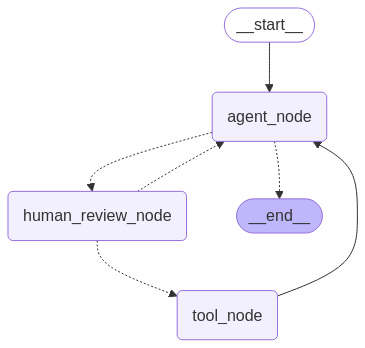

In [6]:

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
thread = {"configurable": {"thread_id": "1"}}

initial_input = {"messages": [{"role": "user", "content": "what's the weather in sf?"}]}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

print("Pending Executions!")
print(graph.get_state(thread).next)    

{'agent_node': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PT4ThNxaRz4QRyu4jVpYezng', 'function': {'arguments': '{"city":"San Francisco"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 97, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-690c1719-03d2-4ad4-9010-cbc7c040641f-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'call_PT4ThNxaRz4QRyu4jVpYezng', 'type': 'tool_call'}], usage_metadata={'input_tokens': 97, 'output_tokens': 16, 'total_tokens': 113, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outp

In [8]:
# RESUME ONLY
user_input = "continue"
for event in graph.stream(Command(resume={"action": user_input}),thread,stream_mode="updates"):
    print(event)

{'human_review_node': None}
----
Searching for: San Francisco
----
{'tool_node': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_5E9HGe0ysHYSx2ZemMMKXtkV'}]}}
{'agent_node': {'messages': [AIMessage(content='The weather in San Francisco is sunny!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 74, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'finish_reason': 'stop', 'logprobs': None}, id='run-6d51ef42-580e-4616-837d-b95e7c67c83d-0', usage_metadata={'input_tokens': 74, 'output_tokens': 10, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [10]:
# UPDATE STATE & RESUME 
custom_tool_arg = "San Francisco, USA"
for event in graph.stream(Command(resume={"action": "update", "data": {"city": custom_tool_arg }}),thread,stream_mode="updates"):
    print(event)  

{'human_review_node': {'messages': [{'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_PT4ThNxaRz4QRyu4jVpYezng', 'name': 'weather_search', 'args': {'city': 'San Francisco, USA'}}], 'id': 'run-690c1719-03d2-4ad4-9010-cbc7c040641f-0'}]}}
----
Searching for: San Francisco, USA
----
{'tool_node': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_PT4ThNxaRz4QRyu4jVpYezng'}]}}
{'agent_node': {'messages': [AIMessage(content='The weather in San Francisco is sunny!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 124, 'total_tokens': 134, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_90122d973c', 'finish_reason': 'stop', 'logprobs': None}, id='run-b87cb84